## Gromov-Wasserstein distance approximation

In [1]:
# -*- coding: utf-8 -*-

In [3]:
#############################################################################
#
# Import the required modules and functions
# ---------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from data_simulators import data_generator
from methods.gromov_funcs import define_loss_function, gw_distance, spar_gw, sampled_gw, entropic_gw
import methods.SGWL.GromovWassersteinGraphToolkit as GwGt
from methods.LRGW.FastGromovWass import apply_quad_lr_gw

np.random.seed(123)

In [4]:
#############################################################################
#
# Define the ground cost function
# ---------------------------------------------

loss_func_name = 'square_loss'  # 'square_loss' for l2 loss; '1_loss' for l1 loss
loss_func = define_loss_function(loss_func_name)

if loss_func_name == 'square_loss':
    gromov_loss_func = loss_func_name
else:
    gromov_loss_func = loss_func

In [5]:
#############################################################################
#
# Setup
# ---------------------------------------------

n_list = np.array([25, 50, 100, 200, 500])  # number of samples
eps_list = np.array([1, 1e-1, 1e-2, 5e-3])  # regularization parameter
nloop = 5  # number of replications for sampling-based methods
dataset_name = 'moon'  # synthetic dataset name, can be chosen from 'moon', 'graph', 'gaussian', and 'spiral'

# Store the estimated GW distances of different methods
dist_emd = np.zeros(len(n_list))
dist_egw = np.zeros([len(n_list), len(eps_list)])
dist_pga = np.zeros([len(n_list), len(eps_list)])
dist_sgwl = np.zeros([len(n_list), len(eps_list)])
dist_lrgw = np.zeros(len(n_list))
dist_sagrow = np.zeros([nloop, len(n_list), len(eps_list)])
dist_spargw = np.zeros([nloop, len(n_list), len(eps_list)])

In [6]:
#############################################################################
#
# Compute the GW distance
# ---------------------------------------------

for j in range(len(n_list)):
    n = n_list[j]
    print('n =', n)
    
    np.random.seed(123+321*j)
    a, b, C1, C2 = data_generator(dataset_name, n)  # a,b are marginal distributions; C1, C2 are relation matrices


    ################ EMD-GW ################
    trans_emd = entropic_gw(C1, C2, a, b, gromov_loss_func, epsilon=0)
    # check if the marginal constraints are approximately satisfied
    if (np.sum(np.abs(np.sum(trans_emd,1)-a)) < 1e-1 and np.sum(np.abs(np.sum(trans_emd,0)-b)) < 1e-1):  
        dist_emd[j] = gw_distance(C1, C2, gromov_loss_func, trans_emd)
    else:
        dist_emd[j] = np.nan
    
    
    ################ LR-GW ################
    rank = int(n/20)+1
    cost_SE = (C1, C2)
    results = apply_quad_lr_gw(np.nan, np.nan, a, b, rank, cost_SE, gamma_0=100, rescale_cost=False, time_out=200)
    res, Q, R, g = results
    trans_lrgw = np.dot(Q/g, R.T)
    if (np.sum(np.abs(np.sum(trans_lrgw,1)-a)) < 1e-1 and np.sum(np.abs(np.sum(trans_lrgw,0)-b)) < 1e-1):
        dist_lrgw[j] = gw_distance(C1, C2, gromov_loss_func, trans_lrgw)
    else:
        dist_lrgw[j] = np.nan
    
    
    for k in range(len(eps_list)):
        epsilon = eps_list[k]

        ################ Spar-GW ################
        for i in range(nloop):
            trans_spargw = spar_gw(C1, C2, a, b, gromov_loss_func, 16*n, epsilon, solver='inexact-proximal', 
                                   random_state=123+100*j+421*i+22*k)
            if np.isnan(np.sum(trans_spargw)):
                dist_spargw[i,j,k] = np.nan
            elif (np.sum(np.abs(np.sum(trans_spargw,1)-a)) < 1e-1 and np.sum(np.abs(np.sum(trans_spargw,0)-b)) < 1e-1):
                dist_spargw[i,j,k] = gw_distance(C1, C2, gromov_loss_func, trans_spargw)
            else:
                dist_spargw[i,j,k] = np.nan
            
        
        ################ SaGroW ################
        for i in range(nloop):
            trans_sagrow = sampled_gw(C1, C2, a, b, loss_func, 16**2, epsilon, con_loop=10,
                                      KL=True, random_state=123+100*j+421*i+22*k)
            if np.isnan(np.sum(trans_sagrow)):
                dist_sagrow[i,j,k] = np.nan
            elif (np.sum(np.abs(np.sum(trans_sagrow,1)-a)) < 1e-1 and np.sum(np.abs(np.sum(trans_sagrow,0)-b)) < 1e-1):
                dist_sagrow[i,j,k] = gw_distance(C1, C2, gromov_loss_func, trans_sagrow)
            else:
                dist_sagrow[i,j,k] = np.nan
   

        ################ S-GWL ################
        ot_dict = {'loss_type': gromov_loss_func, 
                    'ot_method': 'proximal',
                    'beta': epsilon,
                    # outer, inner iteration, error bound of optimal transport
                    'outer_iteration': 100,
                    'iter_bound': 1e-9,
                    'inner_iteration': 10,
                    'sk_bound': 1e-9,
                    'node_prior': 1e3,
                    'max_iter': 4,  # iteration and error bound for calcuating barycenter
                    'cost_bound': 1e-26,
                    'update_p': False,  # optional updates of source distribution
                    'lr': 0,
                    'alpha': 0}

        idx2node_s = {}
        idx2node_t = {}
        for ii in range(n):
            idx2node_s[ii] = ii
        for ii in range(n):
            idx2node_t[ii] = ii
            
        cost_s = csr_matrix(C1)
        cost_t = csr_matrix(C2)

        pairs_idx, pairs_name, pairs_confidence = GwGt.recursive_direct_graph_matching(
            cost_s=cost_s, cost_t=cost_t,
            p_s=a[:,None], p_t=b[:,None],
            idx2node_s=idx2node_s, idx2node_t=idx2node_t, ot_hyperpara=ot_dict,
            weights=None, predefine_barycenter=False, cluster_num=2,
            partition_level=3, max_node_num=0)

        pairs_idx = np.array(pairs_idx)
        trans_sgwl = np.zeros((C1.shape[0], C2.shape[0]))
        trans_sgwl[pairs_idx[:, 0], pairs_idx[:, 1]] = a[pairs_idx[:, 0]]
        trans_sgwl /= np.sum(trans_sgwl)

        if np.isnan(np.sum(trans_sgwl)):
            dist_sgwl[j,k] = np.nan
        else:
            dist_sgwl[j,k] = gw_distance(C1, C2, gromov_loss_func, trans_sgwl)


        ################ EGW ################
        trans_egw = entropic_gw(C1, C2, a, b, gromov_loss_func, epsilon, solver='entropy')
        if (np.sum(np.abs(np.sum(trans_egw,1)-a)) < 1e-1 and np.sum(np.abs(np.sum(trans_egw,0)-b)) < 1e-1):
            dist_egw[j,k] = gw_distance(C1, C2, gromov_loss_func, trans_egw)
        else:
            dist_egw[j,k] = np.nan


        ################ PGA-GW ################
        trans_pga = entropic_gw(C1, C2, a, b, gromov_loss_func, epsilon, solver='inexact-proximal')
        if (np.sum(np.abs(np.sum(trans_pga,1)-a)) < 1e-1 and np.sum(np.abs(np.sum(trans_pga,0)-b)) < 1e-1):
            dist_pga[j,k] = gw_distance(C1, C2, gromov_loss_func, trans_pga)
        else:
            dist_pga[j,k] = np.nan
            
print('Finished!')

n = 25
n = 50
n = 100
n = 200
n = 500
Finished!


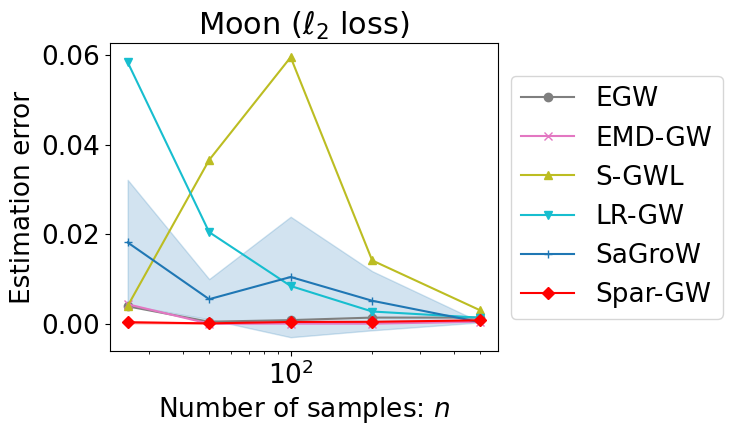

In [7]:
#############################################################################
#
# Plot the estimation error
# ---------------------------------------------

# Compute the mean of errors
mean_dist_sagrow = np.nanmean(dist_sagrow, axis=0)
mean_dist_spargw = np.nanmean(dist_spargw, axis=0)

oracle = np.nanmin(dist_pga, axis=1)
err_egw = np.abs(np.nanmin(dist_egw, axis=1) - oracle)
err_emd = np.abs(dist_emd - oracle)
err_sgwl = np.abs(np.nanmin(dist_sgwl, axis=1) - oracle)
err_lrgw = np.abs(dist_lrgw - oracle)
err_sagrow = np.abs(np.nanmin(mean_dist_sagrow, axis=1) - oracle)
err_spargw = np.abs(np.nanmin(mean_dist_spargw, axis=1) - oracle)

# Compute the standard deviation of errors
meta_oracle = np.tile(np.tile(oracle, (dist_sagrow.shape[2], 1)).T, (dist_sagrow.shape[0], 1, 1))
meta_err_sagrow = abs(dist_sagrow - meta_oracle)
meta_err_spargw = abs(dist_spargw - meta_oracle)

mean_err_sagrow = np.nanmean(meta_err_sagrow, axis=0)
mean_err_spargw = np.nanmean(meta_err_spargw, axis=0)

temp = tuple((np.array(range(len(n_list))), np.nanargmin(mean_err_sagrow, axis=1)))
std_err_sagrow = np.nanstd(meta_err_sagrow, axis=0)[temp[0],temp[1]]
temp = tuple((np.array(range(len(n_list))), np.nanargmin(mean_err_spargw, axis=1)))
std_err_spargw = np.nanstd(meta_err_spargw, axis=0)[temp[0],temp[1]]


plt.figure(1, figsize=(5, 4))
plt.clf()
plt.title(r'Moon ($\ell_2$ loss)', fontsize=22)
plt.plot(n_list, err_egw, color='tab:grey', marker='o', linestyle='-', label='EGW')
plt.plot(n_list, err_emd, color='tab:pink', marker='x', linestyle='-', label='EMD-GW')
plt.plot(n_list, err_sgwl, color='tab:olive', marker='^', linestyle='-', label='S-GWL')
plt.plot(n_list, err_lrgw, color='tab:cyan', marker='v', linestyle='-', label='LR-GW')
plt.plot(n_list, err_sagrow, color='tab:blue', marker='+', linestyle='-', label='SaGroW')
plt.fill_between(n_list, err_sagrow-std_err_sagrow, err_sagrow+std_err_sagrow, color='tab:blue', alpha=0.2)
plt.plot(n_list, err_spargw, color='red', marker='D', linestyle='-', label='Spar-GW')
plt.fill_between(n_list, err_spargw-std_err_spargw, err_spargw+std_err_spargw, color='red', alpha=0.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=19)
plt.xlabel(r'Number of samples: $n$', fontsize=19)
plt.ylabel('Estimation error', fontsize=19)
plt.xscale('log')
plt.tick_params(labelsize=19)
plt.show()